In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from numpy import load
import librosa

X = load('data/musdb_spec_128x26_inputs.npy')
Y = load('data/musdb_spec_128x26_bitmask.npy')
ix = 14

X = np.expand_dims(X, 3)

print(X.shape)
print(Y.shape)
print('Done')

(995880, 128, 26, 1)
(995880, 128)
Done


In [7]:
model = keras.Sequential([
    layers.Conv2D(32, (5,5), input_shape=(128, 26, 1), padding='same'),
    layers.LeakyReLU(),
    layers.Conv2D(16, (5,5), padding='same'),
    layers.LeakyReLU(),
    layers.MaxPool2D(pool_size=(3,3)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.LeakyReLU(),
    layers.Conv2D(16, (3,3), padding='same'),
    layers.LeakyReLU(),
    layers.MaxPool2D(pool_size=(3,3)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='sigmoid')
])

model.compile(optimizer='adadelta', loss='binary_crossentropy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 26, 32)       832       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128, 26, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 26, 16)       12816     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 128, 26, 16)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 42, 8, 16)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 42, 8, 16)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 42, 8, 64)        

In [83]:
# train model
model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.1, use_multiprocessing=True)

Train on 896292 samples, validate on 99588 samples
Epoch 1/10
896292/896292 [==============================] - 6054s 7ms/sample - loss: 0.5448 - val_loss: 0.4271
Epoch 2/10
896292/896292 [==============================] - 5902s 7ms/sample - loss: 0.4196 - val_loss: 0.3893
Epoch 3/10
896292/896292 [==============================] - 5921s 7ms/sample - loss: 0.3904 - val_loss: 0.3731
Epoch 4/10
896292/896292 [==============================] - 5912s 7ms/sample - loss: 0.3754 - val_loss: 0.3683
Epoch 5/10
783488/896292 [=========================>....] - ETA: 12:15 - loss: 0.3663

KeyboardInterrupt: 

In [84]:
model.evaluate(X[100000:200000], Y[100000:200000])

 10208/100000 [==>...........................] - ETA: 2:23 - loss: 0.3313

KeyboardInterrupt: 

In [71]:
import matplotlib.pyplot as plt
import librosa.display

def show_spectrograms(S_input, S_target, S_pred):
    plt.figure()
    ax1 = plt.subplot(3,1,1)
    librosa.display.specshow(S_input)
    plt.title('Input')
    plt.colorbar(format='%+2.0f dB')

    ax2 = plt.subplot(3,1,2)
    librosa.display.specshow(S_target)
    plt.title('Target')
    plt.colorbar(format='%+2.0f dB')
    
    ax3 = plt.subplot(3,1,3)
    librosa.display.specshow(S_pred)
    plt.title('Prediction')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

def spectrogram_to_wavfile(filename, S):
    S = librosa.core.db_to_power(S)
    print('Inverting spectrogram...')
    y = librosa.feature.inverse.mel_to_audio(S)
    print('Creating {}...'.format(filename))
    scipy.io.wavfile.write(filename, 22050, y)
    print('Done')

def predict_bitmask(S):
    S = np.pad(S, [(0, 0), (13, 13)], constant_values=[(0, 0), (-60, -60)])
    S = np.expand_dims(S, 2)

    b = np.empty((128, S.shape[1]-26))
    for i in range(13, S.shape[1]-14):
        x = S[:, i - 13 : i + 13]
        p = model.predict(np.array([x]))[0]
        b[:,i-13] = p
    b = (b > 0.5).astype(int)
    return b

In [91]:
X_ = np.load('data/musdb_spec_inputs.npy')
Y_ = np.load('data/musdb_spec_targets.npy')

ix = 56
x_ = X_[ix]
y_ = Y_[ix]

b = predict_bitmask(x_)
add = (1 - b)*-50
pred = x_ + add

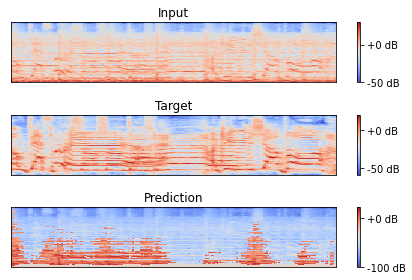

Inverting spectrogram...
Creating audio-files/xpred.wav...
Done
Inverting spectrogram...
Creating audio-files/xtarget.wav...
Done
Inverting spectrogram...
Creating audio-files/xinput.wav...
Done


In [92]:
import scipy.io.wavfile

show_spectrograms(x_, y_, pred)
spectrogram_to_wavfile('audio-files/xpred.wav', pred)
spectrogram_to_wavfile('audio-files/xtarget.wav', y_)
spectrogram_to_wavfile('audio-files/xinput.wav', x_)

In [93]:
np.set_printoptions(linewidth=100, precision=2)
for i in range(len(b)):
    print(b[i])

1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
[0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0